In [3]:
%matplotlib inline
import pandas as pd, numpy as np
import sklearn
import sklearn.dummy
import nltk.stem.snowball
import matplotlib.pyplot as plt

#snow = nltk.stem.snowball.SnowballStemmer("english")

<h1> Articles, Categories </h1>

In [4]:
reut = nltk.corpus.reuters

train = [x for x in reut.fileids() if 'train' in x]
test = [x for x in reut.fileids() if 'test' in x]

articles = [reut.raw(x).upper() for x in reut.fileids()]

cat_train = [pd.DataFrame(
        data = [[1]* len(reut.categories(x))], 
        index = [x], 
        columns = reut.categories(x))
    for x in train]
cat_dums_train = pd.concat(cat_train, axis=0).fillna(0)

cat_test = [pd.DataFrame(
        data = [[1]* len(reut.categories(x))], 
        index = [x], 
        columns = reut.categories(x)) 
    for x in test]

#cats = pd.concat([cat_test, cat_train])
cat_dums_test = pd.concat(cat_test, axis=0).fillna(0)

<h1> Titles </h1>

In [3]:
titles = []

def hypernym(word):
    try:
        rawname = nltk.corpus.wordnet.synsets(word)[0].hypernyms()[0].name()
        return str(rawname.partition(".")[0])
    except IndexError:
        return ''
print

'''def go(start):
    res = []
    hyp = start
    while hyp not in res:
        res.append(hyp)
        hyp = snow.stem(hyp)
    return res
go('car')'''

for x in train:
    filetitle = set()
    for word in reut.words(x):
        hyp = hypernym(word)
        if word == word.upper() and word.isalpha() and hyp!='':
            filetitle.add(hyp)
    titles.append(list(filetitle))

# what to do: use the text to predict the synsets of title words, 
# and as a bonus use the category to predict the title words.

#motor_car = nltk.corpus.wordnet.hypernyms("car")[0]
#bicycle = nltk.corpus.wordnet.synsets("bicycle")[0]
#motor_car.common_hypernyms(bicycle)
#motor_car.lowest_common_hypernyms(bicycle)
#motor_car.path_similarity(bicycle)titles_dummies
    
titles = pd.Series(titles)
titles = titles.apply(lambda x: ' '.join(x))

<h1> Vectorizers </h1>

In [7]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
tfids = tfidf.fit_transform(articles)
tfids_test = tfids[:len(test),:]
tfids_train = tfids[len(test):,:]

countvect = sklearn.feature_extraction.text.CountVectorizer()
#titles_dums = countvect.fit_transform(titles)
tfids_test

<3019x30916 sparse matrix of type '<type 'numpy.float64'>'
	with 211750 stored elements in Compressed Sparse Row format>

<h1> Regression </h1>

In [214]:
#dumReg = sklearn.dummy.DummyClassifier()
#dumReg.fit(tfids_train, cat_train_dums.iloc[:,0])

import sklearn.metrics as met

#logregs = {}
#logreg_coefs = {}
#logreg_probs = {}
#logreg_scores = {}

for cat in cat_dums_train.columns:
    print cat
    logregs[cat] = sklearn.linear_model.LogisticRegressionCV()
    logregs[cat].fit(tfids_train, cat_dums_train.loc[:,cat])
    logreg_coefs[cat] = logregs[cat].coef_[0]
    logreg_probs[cat] = logregs[cat].predict_proba(tfids)[:,1]
    
    preds = logregs[cat].predict(tfids_test)
    logreg_scores[cat] = met.confusion_matrix(preds, 
                                            cat_dums_test.loc[:,cat]).flatten()
                                            
coefs = pd.DataFrame.from_dict(logreg_coefs)
coefs.index = tfidf.get_feature_names()

probs = pd.DataFrame.from_dict(logreg_probs)
probs.index = reut.fileids()
probs[probs<0.001]=0

scores = pd.DataFrame.from_dict(logreg_scores,orient='index')

#scoring metrics
scores.columns = ['TrueNeg','FalseNeg','FalsePos','TruePos']# + list(scores.columns[4:])
scores['Prevalence']=(scores['TruePos']+scores['FalseNeg'])/(scores['TruePos']+scores['TrueNeg']+scores['FalsePos']+scores['FalseNeg'])
scores['Recall'] = scores['TruePos']/(scores['TruePos']+scores['FalseNeg'])
scores['Precision'] = scores['TruePos']/(scores['TruePos']+scores['FalsePos'])
scores['Accuracy'] = (scores['TruePos']+scores['TrueNeg'])/(scores['TruePos']+scores['TrueNeg']+scores['FalsePos']+scores['FalseNeg'])
scores['F1'] = scores['TruePos']*2/(2*scores['TruePos']+scores['FalsePos']+scores['FalseNeg'])
scores = scores.sort_values('F1',ascending=False)

acq
alum
barley
bop
carcass
castor-oil
cocoa
coconut
coconut-oil
coffee
copper
copra-cake
corn
cotton
cotton-oil
cpi
cpu
crude
dfl
dlr
dmk
earn
fuel
gas
gnp
gold
grain
groundnut
groundnut-oil
heat
hog
housing
income
instal-debt
interest
ipi
iron-steel
jet
jobs
l-cattle
lead
lei
lin-oil
livestock
lumber
meal-feed
money-fx
money-supply
naphtha
nat-gas
nickel
nkr
nzdlr
oat
oilseed
orange
palladium
palm-oil
palmkernel
pet-chem
platinum
potato
propane
rand
rape-oil
rapeseed
reserves
retail
rice
rubber
rye
ship
silver
sorghum
soy-meal
soy-oil
soybean
strategic-metal
sugar
sun-meal
sun-oil
sunseed
tea
tin
trade
veg-oil
wheat
wpi
yen
zinc


In [262]:
scores

,TrueNeg,FalseNeg,FalsePos,TruePos,Recall,Precision,Accuracy,F1,Prevalence
lei,3016,0,0,3,1.000000,1.000000,1.000000,1.000000,0.000994
earn,1920,22,12,1065,0.979761,0.988858,0.988738,0.984288,0.360053
cocoa,3001,1,0,17,0.944444,1.000000,0.999669,0.971429,0.005962
acq,2290,36,10,683,0.949930,0.985570,0.984763,0.967422,0.238158
coffee,2990,1,1,27,0.964286,0.964286,0.999338,0.964286,0.009275
ipi,3007,1,0,11,0.916667,1.000000,0.999669,0.956522,0.003975
grain,2865,29,5,120,0.805369,0.960000,0.988738,0.875912,0.049354
crude,2816,37,14,152,0.804233,0.915663,0.983107,0.856338,0.062604
gnp,2984,9,0,26,0.742857,1.000000,0.997019,0.852459,0.011593
sugar,2982,9,1,27,0.750000,0.964286,0.996688,0.843750,0.011924


<h1> Analysis </h1>

In [194]:
def topcats(s, num):
    top = s.sort_values(ascending=False)[:num]
    top = top.reset_index()
    top.index = ['Top ' + str(x) for x in range(1, num+1)]
    top.columns = ['Category','Prob']
    top = top.stack()
    return top

top5probs = probs.apply(lambda s: topcats(s,5), axis=1)

cats = pd.Series([reut.categories(x) for x in reut.fileids()],
                    index=reut.fileids())

top5probs['RealCats'] = cats
top5probs[top5probs.columns[-1:] | top5probs.columns[:-1]]

RealCats     Top 1  \
                                                                  Category   
test/14826                                               [trade]     trade   
test/14828                                               [grain]     grain   
test/14829                                      [crude, nat-gas]     crude   
test/14832        [corn, grain, rice, rubber, sugar, tin, trade]     trade   
test/14833                                   [palm-oil, veg-oil]   veg-oil   
test/14839                                                [ship]      ship   
test/14840           [coffee, lumber, palm-oil, rubber, veg-oil]    coffee   
test/14841                                        [grain, wheat]     wheat   
test/14842                                                [gold]      gold   
test/14843                                                 [acq]       acq   
test/14844                                                 [tin]       acq   
test/14849                                  [interest, money-fx]  interest   
test/14852                                         [acq, copper]       acq   
test/14854                                                 [ipi]       ipi   
test/14858     [carcass, corn, grain, livestock, oilseed, ric...     trade   
test/14859                                                [earn]      earn   
test/14860                                                [earn]      earn   
test/14861                                  [interest, money-fx]  money-fx   
test/14862                                          [bop, trade]       bop   
test/14863                                           [gas, lead]     crude   
test/14865                                                 [acq]       acq   
test/14867                                                [jobs]       ipi   
test/14872                                                [earn]      earn   
test/14873                                                [earn]      earn   
test/14875                                                [earn]      earn   
test/14876                                                [earn]      earn   
test/14877                                                 [tin]       tin   
test/14881                                               [trade]     trade   
test/14882                                                [zinc]      zinc   
test/14885                                               [sugar]     sugar   
...                                                          ...       ...   
training/9956                                             [earn]      earn   
training/9957                                  [money-fx, trade]     trade   
training/9958                              [barley, corn, grain]    barley   
training/9959                                             [earn]      earn   
training/9961                                             [earn]      earn   
training/9963                                             [earn]      earn   
training/9964                                             [earn]      earn   
training/9965                                             [earn]      earn   
training/9967                                             [earn]      earn   
training/9970                                             [earn]      earn   
training/9971                                              [acq]       acq   
training/9972                                         [interest]  money-fx   
training/9973                                             [earn]      earn   
training/9974                                           [retail]    retail   
training/9975                                         [money-fx]  money-fx   
training/9976                                              [acq]       acq   
training/9977                                              [acq]       acq   
training/9978                                              [acq]       acq   
training/998                                              [earn]      earn   


In [277]:
def topandbot(s, num):
    
    top = s.sort_values(ascending=False)[:num]
    bot = s.sort_values(ascending=True)[:num]

    top = top.reset_index()
    bot = bot.reset_index()
    
    top.index = ['Top ' + str(x) for x in range(1, num+1)]
    bot.index = ['Bottom ' + str(x) for x in range(1, num+1)]
    
    tmp = pd.concat([top, bot])
    tmp.columns = ['Word','Coef']
    
    return tmp.stack()

top5coefs = coefs.apply(lambda s: topandbot(s,5)).transpose()
top5coefs['F1'] = scores['F1']
top5coefs['Recall'] = scores['Recall']

def AvgCoefs(x):
    tot = 0
    for i in range(1,6):
        nm = 'Top ' + str(i)
        tot += x[nm, 'Coef']
    return tot/5

top5coefs['AvgCoef'] = top5coefs.apply(AvgCoefs, axis=1) 
top5coefs[top5coefs['F1']<0.5]

Top 1                       Top 2               \
                          Word         Coef           Word         Coef   
alum                 aluminium      34.3448       aluminum      23.2356   
castor-oil          castorseed  3.74581e-05         castor  3.47503e-05   
coconut                coconut   0.00017082     philippine  6.39047e-05   
coconut-oil               oils  7.81332e-05        coconut  6.45871e-05   
copra-cake               copra  7.23873e-05      indonesia  4.28693e-05   
cotton-oil              offers  4.02357e-05          egypt  3.78175e-05   
cpu                         79  9.38029e-05            pct  7.55308e-05   
dfl                        cpb   5.8806e-05          dutch   4.6463e-05   
dmk                       mark      11.0737           lira      10.5267   
fuel                      fuel      10.1958        sulphur      9.72034   
groundnut              peanuts  6.52541e-05           ascs  5.08708e-05   
groundnut-oil           tonnes  3.77922e-05            fat  3.32342e-05   
income                     pct  0.000166782           rose  0.000140555   
instal-debt             credit      15.0542       consumer      7.91833   
jet                   contract  7.72778e-05           fuel  7.42121e-05   
l-cattle                cattle  0.000210585            the  7.18336e-05   
lead                      zinc  0.000232122           lead  0.000224083   
lin-oil                   prev  4.79023e-05            apr  3.38742e-05   
livestock                 beef       22.463           pork      19.1459   
lumber                  lumber  0.000141793        plywood  0.000109414   
meal-feed                 feed      13.3285           meal      11.7757   
naphtha               pakistan  5.58262e-05         diesel  4.17705e-05   
nickel                  nickel  0.000201585       platinum  0.000113482   
nkr                    finland  4.28411e-05          crown   4.0625e-05   
nzdlr                  zealand  3.85035e-05        muldoon  3.57372e-05   
oat                       oats  0.000128333           corn  0.000105299   
palladium             platinum      6.16815      technigen       3.1201   
palmkernel                palm  4.89155e-05        ringgit  4.73535e-05   
pet-chem              ethylene      9.43108  petrochemical      9.05871   
platinum              platinum  0.000177505            tvx   5.8308e-05   
potato                  potato  7.14912e-05           cwts  6.15839e-05   
propane                propane  7.12588e-05            the  4.16098e-05   
rand                      rand  7.98503e-05         africa  4.74066e-05   
rape-oil                   oil  8.75566e-05       rapeseed  7.85938e-05   
rice                      rice      35.1271          paddy      10.5573   
rye                         04  2.63391e-05             05  1.67539e-05   
silver                  silver      29.4604          idaho      8.17677   
sorghum                sorghum      26.0542           prev      8.40508   
soy-meal                tonnes   0.00017499        soymeal  0.000141821   
soy-oil                soybean      15.5521       soyabean      11.7713   
strategic-metal        uranium  0.000162282           rare  0.000109511   
sun-meal             expellers   4.1308e-05        pellets  3.94191e-05   
sun-oil          sunflowerseed  0.000105802            oil  8.83345e-05   
sunseed                     ha      6.41649        sowings      6.01577   
tea                        tea   0.00014746   countertrade  8.81142e-05   
yen                        yen      19.3276       japanese      8.47642   

                         Top 3                       Top 4               \
                          Word         Coef           Word         Coef   
alum                        20      15.3435        alumina      13.6153   
castor-oil              tonnes  2.76358e-05  provisionally  2.74176e-05   
coconut                  copra  4.07161e-05        exports  3.54275e-05   
coconut-oil          vegetable  5.73284e-05      

<h1> Plots </h1>

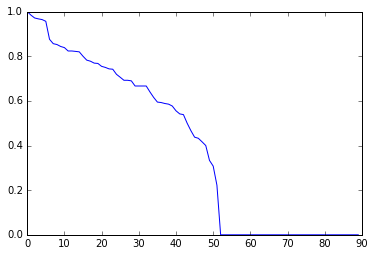

In [238]:
plt.plot(list(scores['F1']))

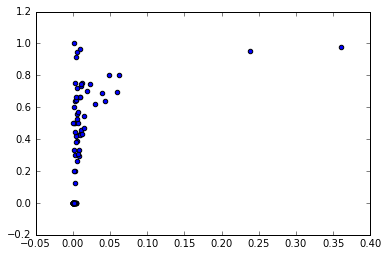

In [280]:
plt.scatter(scores.sort_values(by='F1')['Prevalence'],top5coefs.sort_values(by='F1')['Recall'])

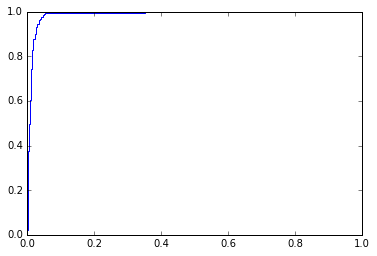

In [279]:
catn = 'money-fx'
Y_test = cat_dums_test[catn]
Y_scoring = logregs[catn].decision_function(tfids_test)
fpr, tpr, decision = sklearn.metrics.roc_curve(Y_test, Y_scoring)
plt.plot(fpr,tpr)